In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
%qtconsole

# 8 Observer Bias

## 8.1 The Red Line problem

In Massachusetts, the Red Line is a subway that connects Cambridge and
Boston. When I was working in Cambridge I took the Red Line from Kendall
Square to South Station and caught the commuter rail to Needham. During
rush hour Red Line trains run every 7–8 minutes, on average.

When I arrived at the station, I could estimate the time until the next
train based on the number of passengers on the platform. If there were
only a few people, I inferred that I just missed a train and expected to
wait about 7 minutes. If there were more passengers, I expected the
train to arrive sooner. But if there were a large number of passengers,
I suspected that trains were not running on schedule, so I would go back
to the street level and get a taxi.

While I was waiting for trains, I thought about how Bayesian estimation
could help predict my wait time and decide when I should give up and
take a taxi. This chapter presents the analysis I came up with.

This chapter is based on a project by Brendan Ritter and Kai Austin, who
took a class with me at Olin College. The code in this chapter is
available from <http://thinkbayes.com/redline.py>. The code I used to
collect data is in <http://thinkbayes.com/redline_data.py>. For more
information see Section [download].

## 8.2 The model

Before we get to the analysis, we have to make some modeling decisions.
First, I will treat passenger arrivals as a Poisson process, which means
I assume that passengers are equally likely to arrive at any time, and
that they arrive at an unknown rate, $\lambda$, measured in passengers
per minute. Since I observe passengers during a short period of time,
and at the same time every day, I assume that $\lambda$ is constant.

On the other hand, the arrival process for trains is not Poisson. Trains
to Boston are supposed to leave from the end of the line (Alewife
station) every 7–8 minutes during peak times, but by the time they get
to Kendall Square, the time between trains varies between 3 and 12
minutes.

To gather data on the time between trains, I wrote a script that
downloads real-time data from
<http://www.mbta.com/rider_tools/developers/>, selects south-bound
trains arriving at Kendall square, and records their arrival times in a
database. I ran the script from 4pm to 6pm every weekday for 5 days, and
recorded about 15 arrivals per day. Then I computed the time between
consecutive arrivals; the distribution of these gaps is shown in
Figure 7.1, labeled `z`.

If you stood on the platform from 4pm to 6pm and recorded the time
between trains, this is the distribution you would see. But if you
arrive at some random time (without regard to the train schedule) you
would see a different distribution. The average time between trains, as
seen by a random passenger, is substantially higher than the true
average.

Why? Because a passenger is more like to arrive during a large interval
than a small one. Consider a simple example: suppose that the time
between trains is either 5 minutes or 10 minutes with equal probability.
In that case the average time between trains is 7.5 minutes.

But a passenger is more likely to arrive during a 10 minute gap than a 5
minute gap; in fact, twice as likely. If we surveyed arriving
passengers, we would find that 2/3 of them arrived during a 10 minute
gap, and only 1/3 during a 5 minute gap. So the average time between
trains, as seen by an arriving passenger, is 8.33 minutes.

This kind of **observer bias** appears in many contexts.
Students think that classes are bigger than they are because more of
them are in the big classes. Airline passengers think that planes are
fuller than they are because more of them are on full flights.

In each case, values from the actual distribution are oversampled in
proportion to their value. In the Red Line example, a gap that is twice
as big is twice as likely to be observed.

So given the actual distribution of gaps, we can compute the
distribution of gaps as seen by passengers:

In [24]:
#observed gap times z
z = observed_gap_times = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0 ])

def get_kde(all_values,est_values):
    #see chapter 6.1
    kernel = stats.gaussian_kde(all_values)
    pmf = kernel.evaluate(est_values)
    pmf = pmf/pmf.sum()
    return pmf

z_xk = np.linspace(0,1200,101)
z_pmf = get_kde(z,z_xk)

zb_pmf = z_pmf * z_xk
zb_pmf = zb_pmf / zb_pmf.sum()

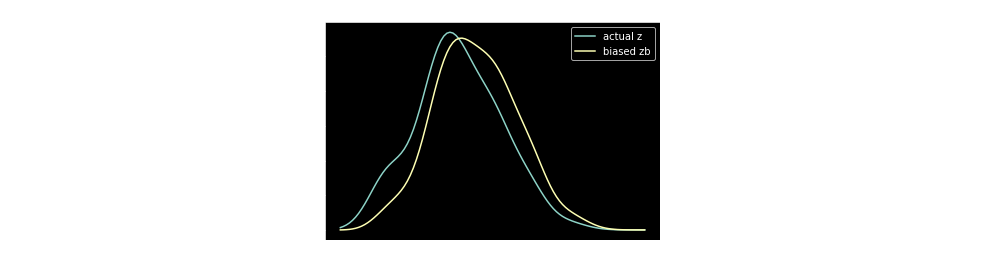

In [25]:
#Figure 8.1
plt.plot(z_xk/60, z_pmf , label='actual z')
plt.plot(z_xk/60, zb_pmf, label='biased zb')
plt.xlabel('Time (min)');
plt.ylabel('PMF');
plt.legend()
plt.title('Figure 8.1: PMF of gaps between trains, based on collected data, smoothed by KDE. z is the actual distribution; zb is the biased distribution seen by passengers.');

`z_pmf` is the actual distribution; `zb_pmf` is the biased
distribution. Inside the loop, we multiply the probability of each
value, `z_pmf`, by the likelihood it will be observed, which is
proportional to `z_xk`. Then we normalize the result.

Figure 8.1 shows the actual distribution of gaps, labeled
`z`, and the distribution of gaps seen by passengers, labeled
`zb` for “z biased”.

## 8.3 Wait times

Wait time, which I call `y`, is the time between the arrival
of a passenger and the next arrival of a train. Elapsed time, which I
call `x`, is the time between the arrival of the previous
train and the arrival of a passenger. I chose these definitions so that
`zb = x + y`.

Given the distribution of `zb`, we can compute the
distribution of `y`. I’ll start with a simple case and then
generalize. Suppose, as in the previous example, that `zb` is
either 5 minutes with probability 1/3, or 10 minutes with probability
2/3.

If we arrive at a random time during a 5 minute gap, `y` is
uniform from 0 to 5 minutes. If we arrive during a 10 minute gap,
`y` is uniform from 0 to 10. So the overall distribution is a
mixture of uniform distributions weighted according to the probability
of each gap.

The following function takes the distribution of `zb` and
computes the distribution of `y`:

In [33]:
pmfs_uniform = np.tile(z_xk,(z_xk.size,1)) <= z_xk[:,None]
pmfs_uniform = pmfs_uniform / pmfs_uniform.sum(axis=1)[:,None]
#calculating the mixture see Chapter 5.6
y_pmf = (pmfs_uniform * zb_pmf[:,None]).sum(axis=0)

`pmfs_uniform` is a 2D array where each wor are `z_xk`. In each row, values lower than the corresponding values of `z_xk` are found. Then the `True` values are implicitly converted to 1 and summed over 1-axis. Finally, the array of sums is used to normalize each row in `pmfs_uniform` and, thus, get the intended uniform distributions. After that the mixture of all niform distributions is obtained weigting each uniform distribution with the corresponding PMF values from the biased distribution of waiting times `zb_pmf`. 

The array, `z_pmf`, is the unbiased distribution of `z`.
`zb_pmf` is the biased distribution of gap time, as seen by passengers.

`y_pmf` is the distribution of wait time. `x_pmf` is the distribution of
elapsed time, which is the same as the distribution of wait time. To see
why, remember that for a particular value of `zb`, the
distribution of `y` is uniform from 0 to `zb`. Also `x = zb - y`. So the distribution of `x` is also uniform from 0 to `zb`.

Figure 8.2 shows the distribution of `z`,
`zb`, and `y` based on the data I collected from
the Red Line web site.

To present these distributions, I am switching from PMFs to CDFs. Most
people are more familiar with PMFs, but I think CDFs are easier to
interpret, once you get used to them. And if you want to plot several
distributions on the same axes, CDFs are the way to go.

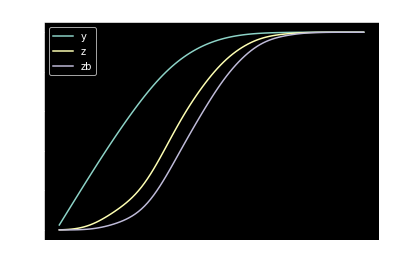

In [34]:
#Figure 8.2
plt.plot(z_xk/60,y_pmf.cumsum(), label='y')
plt.plot(z_xk/60,z_pmf.cumsum(), label='z')
plt.plot(z_xk/60,zb_pmf.cumsum(),label='zb')
plt.xlabel('Time (min)');
plt.ylabel('CDF');
plt.legend()
plt.title('Figure 8.2: CDF of z, zb, and the wait time seen by passengers, y.');

In [40]:
print(f'mean Z {(z_xk*z_pmf).sum()/60:1.1f}, mean zb {(z_xk*zb_pmf).sum()/60:1.1f}, mean y {(z_xk*y_pmf).sum()/60:1.1f}')

mean Z 7.8, mean zb 8.9, mean y 4.4


The mean of `z` is 7.8 minutes. The mean of `zb`
is 8.8 minutes, about 13% higher. The mean of `y` is 4.4,
half the mean of `zb`.

As an aside, the Red Line schedule reports that trains run every 9
minutes during peak times. This is close to the average of
`zb`, but higher than the average of `z`. I
exchanged email with a representative of the MBTA, who confirmed that
the reported time between trains is deliberately conservative in order
to account for variability.

## 8.4 Predicting wait times

Let’s get back to the motivating question: suppose that when I arrive at
the platform I see 10 people waiting. How long should I expect to wait
until the next train arrives?

As always, let’s start with the easiest version of the problem and work
our way up. Suppose we are given the actual distribution of
`z`, and we know that the passenger arrival rate, $\lambda$,
is 2 passengers per minute.

In that case we can:

1.  Use the distribution of `z` to compute the prior
    distribution of `zp`, the time between trains as seen by
    a passenger.

2.  Then we can use the number of passengers to estimate the
    distribution of `x`, the elapsed time since the last
    train.

3.  Finally, we use the relation `y = zp - x` to get the
    distribution of `y`.

The first step is to create a `WaitTimeCalculator` that
encapsulates the distributions of `zp`, `x`, and
`y`, prior to taking into account the number of passengers.

In [0]:
wtc = WaitTimeCalculator(pmf_z)

`pmf_z` is the given distribution of gap times.

The next step is to make an `ElapsedTimeEstimator` (defined
below), which encapsulates the posterior distribution of `x`
and the predictive distribution of `y`.

In [0]:
ete = ElapsedTimeEstimator(wtc,
                           lam=2.0/60,
                           num_passengers=15)

The parameters are the `WaitTimeCalculator`, the passenger
arrival rate, `lam` (expressed in passengers per second), and
the observed number of passengers, let’s say 15.

Here is the definition of `ElapsedTimeEstimator`:

In [0]:
class ElapsedTimeEstimator(object):

    def __init__(self, wtc, lam, num_passengers):
        self.prior_x = Elapsed(wtc.pmf_x)

        self.post_x = self.prior_x.Copy()
        self.post_x.Update((lam, num_passengers))

        self.pmf_y = PredictWaitTime(wtc.pmf_zb, self.post_x)

`prior_x` and `posterior_x` are the prior and posterior distributions of
elapsed time. `pmf_y` is the predictive distribution of wait time.

`ElapsedTimeEstimator` uses `Elapsed` and
`PredictWaitTime`, defined below.

`Elapsed` is a Suite that represents the hypothetical
distribution of `x`. The prior distribution of `x`
comes straight from the `WaitTimeCalculator`. Then we use the
data, which consists of the arrival rate, `lam`, and the
number of passengers on the platform, to compute the posterior
distribution.

Here’s the definition of `Elapsed`:

In [0]:
class Elapsed(thinkbayes.Suite):

    def Likelihood(self, data, hypo):
        x = hypo
        lam, k = data
        like = thinkbayes.EvalPoissonPmf(k, lam * x)
        return like

As always, `Likelihood` takes a hypothesis and data, and
computes the likelihood of the data under the hypothesis. In this case
`hypo` is the elapsed time since the last train and
`data` is a tuple of `lam` and the number of
passengers.

The likelihood of the data is the probability of getting `k`
arrivals in `x` time, given arrival rate `lam`. We
compute that using the PMF of the Poisson distribution.

Finally, here’s the definition of `PredictWaitTime`:

In [0]:
def PredictWaitTime(pmf_zb, pmf_x):
    pmf_y = pmf_zb - pmf_x
    RemoveNegatives(pmf_y)
    return pmf_y

`pmf_zb` is the distribution of gaps between trains; `pmf_x` is the
distribution of elapsed time, based on the observed number of
passengers. Since `y = zb - x`, we can compute

In [0]:
pmf_y = pmf_zb - pmf_x

The subtraction operator invokes `Pmf.__sub__`, which enumerates all
pairs of `zb` and `x`, computes the differences,
and adds the results to `pmf_y`.

The resulting Pmf includes some negative values, which we know are
impossible. For example, if you arrive during a gap of 5 minutes, you
can’t wait more than 5 minutes. `RemoveNegatives` removes the
impossible values from the distribution and renormalizes.

In [0]:
def RemoveNegatives(pmf):
    for val in pmf.Values():
        if val < 0:
            pmf.Remove(val)
    pmf.Normalize()

Figure [fig.redline3] shows the results. The prior distribution of
`x` is the same as the distribution of `y` in
Figure [fig.redline2]. The posterior distribution of `x`
shows that, after seeing 15 passengers on the platform, we believe that
the time since the last train is probably 5-10 minutes. The predictive
distribution of `y` indicates that we expect the next train
in less than 5 minutes, with about 80% confidence.

## Estimating the arrival rate

![Prior and posterior distributions of `lam` based on five
days of passenger data. ](figs/redline1.pdf)

[fig.redline1]

The analysis so far has been based on the assumption that we know (1)
the distribution of gaps and (2) the passenger arrival rate. Now we are
ready to relax the second assumption.

Suppose that you just moved to Boston, so you don’t know much about the
passenger arrival rate on the Red Line. After a few days of commuting,
you could make a guess, at least qualitatively. With a little more
effort, you could estimate $\lambda$ quantitatively.

Each day when you arrive at the platform, you should note the time and
the number of passengers waiting (if the platform is too big, you could
choose a sample area). Then you should record your wait time and the
number of new arrivals while you are waiting.

After five days, you might have data like this:

    k1      y     k2
    --     ---    --
    17     4.6     9
    22     1.0     0
    23     1.4     4
    18     5.4    12
    4      5.8    11

where `k1` is the number of passengers waiting when you
arrive, `y` is your wait time in minutes, and `k2`
is the number of passengers who arrive while you are waiting.

Over the course of one week, you waited 18 minutes and saw 36 passengers
arrive, so you would estimate that the arrival rate is 2 passengers per
minute. For practical purposes that estimate is good enough, but for the
sake of completeness I will compute a posterior distribution for
$\lambda$ and show how to use that distribution in the rest of the
analysis.

`ArrivalRate` is a `Suite` that represents
hypotheses about $\lambda$. As always, `Likelihood` takes a
hypothesis and data, and computes the likelihood of the data under the
hypothesis.

In this case the hypothesis is a value of $\lambda$. The data is a pair,
`y, k`, where `y` is a wait time and
`k` is the number of passengers that arrived.

In [0]:
class ArrivalRate(thinkbayes.Suite):

    def Likelihood(self, data, hypo):
        lam = hypo
        y, k = data
        like = thinkbayes.EvalPoissonPmf(k, lam * y)
        return like

This `Likelihood` might look familiar; it is almost identical
to `Elapsed.Likelihood` in Section [elapsed]. The difference
is that in `Elapsed.Likelihood` the hypothesis is
`x`, the elapsed time; in `ArrivalRate.Likelihood`
the hypothesis is `lam`, the arrival rate. But in both cases
the likelihood is the probability of seeing `k` arrivals in
some period of time, given `lam`.

`ArrivalRateEstimator` encapsulates the process of estimating
$\lambda$. The parameter, `passenger_data`, is a list of `k1, y,
k2` tuples, as in the table above.

In [0]:
class ArrivalRateEstimator(object):

    def __init__(self, passenger_data):
        low, high = 0, 5
        n = 51
        hypos = numpy.linspace(low, high, n) / 60

        self.prior_lam = ArrivalRate(hypos)

        self.post_lam = self.prior_lam.Copy()
        for k1, y, k2 in passenger_data:
            self.post_lam.Update((y, k2))

`__init__` builds `hypos`, which is a sequence of
hypothetical values for `lam`, then builds the prior
distribution, `prior_lam`. The `for` loop updates the prior
with data, yielding the posterior distribution, `post_lam`.

Figure [fig.redline1] shows the prior and posterior distributions. As
expected, the mean and median of the posterior are near the observed
rate, 2 passengers per minute. But the spread of the posterior
distribution captures our uncertainty about $\lambda$ based on a small
sample.

## Incorporating uncertainty

![Predictive distributions of `y` for possible values of
`lam`. ](figs/redline4.pdf)

[fig.redline4]

Whenever there is uncertainty about one of the inputs to an analysis, we
can take it into account by a process like this:

1.  Implement the analysis based on a deterministic value of the
    uncertain parameter (in this case $\lambda$).

2.  Compute the distribution of the uncertain parameter.

3.  Run the analysis for each value of the parameter, and generate a set
    of predictive distributions.

4.  Compute a mixture of the predictive distributions, using the weights
    from the distribution of the parameter.

We have already done steps (1) and (2). I wrote a class called
`WaitMixtureEstimator` to handle steps (3) and (4).

class WaitMixtureEstimator(object):

    def __init__(self, wtc, are, num_passengers=15):
        self.metapmf = thinkbayes.Pmf()

        for lam, prob in sorted(are.post_lam.Items()):
            ete = ElapsedTimeEstimator(wtc, lam, num_passengers)
            self.metapmf.Set(ete.pmf_y, prob)

        self.mixture = thinkbayes.MakeMixture(self.metapmf)

`wtc` is the `WaitTimeCalculator` that contains
the distribution of `zb`. `are` is the
`ArrivalTimeEstimator` that contains the distribution of
`lam`.

The first line makes a meta-Pmf that maps from each possible
distribution of `y` to its probability. For each value of
`lam`, we use `ElapsedTimeEstimator` to compute
the corresponding distribution of `y` and store it in the
Meta-Pmf. Then we use `MakeMixture` to compute the mixture.

Figure [fig.redline4] shows the results. The shaded lines in the
background are the distributions of `y` for each value of
`lam`, with line thickness that represents likelihood. The
dark line is the mixture of these distributions.

In this case we could get a very similar result using a single point
estimate of `lam`. So it was not necessary, for practical
purposes, to include the uncertainty of the estimate.

In general, it is important to include variability if the system
response is non-linear; that is, if small changes in the input can cause
big changes in the output. In this case, posterior variability in
`lam` is small and the system response is approximately
linear for small perturbations.

## Decision analysis 

![Probability that wait time exceeds 15 minutes as a function of the
number of passengers on the platform. ](figs/redline5.pdf)

[fig.redline5]

At this point we can use the number of passengers on the platform to
predict the distribution of wait times. Now let’s get to the second part
of the question: when should I stop waiting for the train and go catch a
taxi?

Remember that in the original scenario, I am trying to get to South
Station to catch the commuter rail. Suppose I leave the office with
enough time that I can wait 15 minutes and still make my connection at
South Station.

In that case I would like to know the probability that `y`
exceeds 15 minutes as a function of `num_passengers`. It is easy enough
to use the analysis from Section [elapsed] and run it for a range of
`num_passengers`.

But there’s a problem. The analysis is sensitive to the frequency of
long delays, and because long delays are rare, it is hard estimate their
frequency.

I only have data from one week, and the longest delay I observed was 15
minutes. So I can’t estimate the frequency of longer delays accurately.

However, I can use previous observations to make at least a coarse
estimate. When I commuted by Red Line for a year, I saw three long
delays caused by a signaling problem, a power outage, and “police
activity” at another stop. So I estimate that there are about 3 major
delays per year.

But remember that my observations are biased. I am more likely to
observe long delays because they affect a large number of passengers. So
we should treat my observations as a sample of `zb` rather
than `z`. Here’s how we can do that.

During my year of commuting, I took the Red Line home about 220 times.
So I take the observed gap times, `gap_times`, generate a sample of 220
gaps, and compute their Pmf:

In [0]:
import thinkbayes

n = 220
cdf_z = thinkbayes.MakeCdfFromList(gap_times)
sample_z = cdf_z.Sample(n)
pmf_z = thinkbayes.MakePmfFromList(sample_z)

Next I bias `pmf_z` to get the distribution of `zb`, draw a
sample, and then add in delays of 30, 40, and 50 minutes (expressed in
seconds):

In [0]:
cdf_zp = BiasPmf(pmf_z).MakeCdf()
sample_zb = cdf_zp.Sample(n) + [1800, 2400, 3000]

`Cdf.Sample` is more efficient than `Pmf.Sample`,
so it is usually faster to convert a Pmf to a Cdf before sampling.

Next I use the sample of `zb` to estimate a Pdf using KDE,
and then convert the Pdf to a Pmf:

In [0]:
pdf_zb = thinkbayes.EstimatedPdf(sample_zb)
xs = MakeRange(low=60)
pmf_zb = pdf_zb.MakePmf(xs)

Finally I unbias the distribution of `zb` to get the
distribution of `z`, which I use to create the
`WaitTimeCalculator`:

In [0]:
pmf_z = UnbiasPmf(pmf_zb)
wtc = WaitTimeCalculator(pmf_z)

This process is complicated, but all of the steps are operations we have
seen before. Now we are ready to compute the probability of a long wait.

In [0]:
def ProbLongWait(num_passengers, minutes):
    ete = ElapsedTimeEstimator(wtc, lam, num_passengers)
    cdf_y = ete.pmf_y.MakeCdf()
    prob = 1 - cdf_y.Prob(minutes * 60)

Given the number of passengers on the platform,
`ProbLongWait` makes an `ElapsedTimeEstimator`,
extracts the distribution of wait time, and computes the probability
that wait time exceeds `minutes`.

Figure [fig.redline5] shows the result. When the number of passengers is
less than 20, we infer that the system is operating normally, so the
probability of a long delay is small. If there are 30 passengers, we
estimate that it has been 15 minutes since the last train; that’s longer
than a normal delay, so we infer that something is wrong and expect
longer delays.

If we are willing to accept a 10% chance of missing the connection at
South Station, we should stay and wait as long as there are fewer than
30 passengers, and take a taxi if there are more.

Or, to take this analysis one step further, we could quantify the cost
of missing the connection and the cost of taking a taxi, then choose the
threshold that minimizes expected cost.

## Discussion

The analysis so far has been based on the assumption that the arrival
rate of passengers is the same every day. For a commuter train during
rush hour, that might not be a bad assumption, but there are some
obvious exceptions. For example, if there is a special event nearby, a
large number of people might arrive at the same time. In that case, the
estimate of `lam` would be too low, so the estimates of
`x` and `y` would be too high.

If special events are as common as major delays, it would be important
to include them in the model. We could do that by extending the
distribution of `lam` to include occasional large values.

We started with the assumption that we know distribution of
`z`. As an alternative, a passenger could estimate
`z`, but it would not be easy. As a passenger, you only
observe only your own wait time, `y`. Unless you skip the
first train and wait for the second, you don’t observe the gap between
trains, `z`.

However, we could make some inferences about `zb`. If we note
the number of passengers waiting when we arrive, we can estimate the
elapsed time since the last train, `x`. Then we observe
`y`. If we add the posterior distribution of `x`
to the observed `y`, we get a distribution that represents
our posterior belief about the observed value of `zb`.

We can use this distribution to update our beliefs about the
distribution of `zb`. Finally, we can compute the inverse of
`BiasPmf` to get from the distribution of `zb` to
the distribution of `z`.

I leave this analysis as an exercise for the reader. One suggestion: you
should read Chapter [species] first. You can find the outline of a
solution in <http://thinkbayes.com/redline.py>. For more information see
Section [download].

## Exercises


This exercise is from MacKay, *Information Theory, Inference, and
Learning Algorithms*:

> Unstable particles are emitted from a source and decay at a distance
> $x$, a real number that has an exponential probability distribution
> with [parameter] $\lambda$. Decay events can only be observed if they
> occur in a window extending from $x=1$ cm to $x=20$ cm. $N$ decays are
> observed at locations $\{ 1.5, 2, 3, 4, 5, 12 \}$ cm. What is the
> posterior distribution of $\lambda$?

You can download a solution to this exercise from
<http://thinkbayes.com/decay.py>.